In [20]:
from pylab import cm
from sklearn import metrics
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from qiskit import QuantumCircuit
from qiskit.circuit import ParameterVector
from qiskit.visualization import circuit_drawer
from qiskit.circuit.library import ZZFeatureMap, PauliFeatureMap, ZFeatureMap
from qiskit_algorithms.optimizers import SPSA
from qiskit_machine_learning.kernels import TrainableFidelityQuantumKernel, TrainableKernel, FidelityQuantumKernel
from qiskit_machine_learning.kernels.algorithms import QuantumKernelTrainer
from qiskit_machine_learning.algorithms import QSVR
from qiskit_machine_learning.datasets import ad_hoc_data
from qiskit_algorithms.utils import algorithm_globals
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn import datasets
from qiskit_machine_learning.utils.loss_functions import KernelLoss, SVCLoss
from typing import Sequence
from sklearn.svm import SVC, SVR
from sklearn.metrics import mean_squared_error
from functools import partial

In [21]:
class QKTCallback:
    """Callback wrapper class."""

    def __init__(self) -> None:
        self._data = [[] for i in range(5)]

    def callback(self, x0, x1=None, x2=None, x3=None, x4=None):
        """
        Args:
            x0: number of function evaluations
            x1: the parameters
            x2: the function value
            x3: the stepsize
            x4: whether the step was accepted
        """
        self._data[0].append(x0)
        self._data[1].append(x1)
        self._data[2].append(x2)
        self._data[3].append(x3)
        self._data[4].append(x4)

    def get_callback_data(self):
        return self._data

    def clear_callback_data(self):
        self._data = [[] for i in range(5)]

class SVRLoss(KernelLoss):
    r"""
    This class provides a kernel loss function for classification tasks by fitting an ``SVR`` model
    from scikit-learn. Given training samples, :math:`x_{i}`, with regression continous values :math:`y_{i}`,
    and a kernel, :math:`K_{θ}`, parameterized by values, :math:`θ`, the loss is defined as:

    .. math:: SVRLoss = \frac{1}{2}\sum_{i=1}^{l}\sum_{j=1}^{l}K(x_{i},x_{j})(\alpha_{i}-\alpha_{i}^{*})(\alpha_{j}-\alpha_{j}^{*})+\epsilon\sum_{i=1}^{l}(\alpha_{i}+\alpha_{i}^{*})-\sum_{i=1}^{l}y_{i}(\alpha_{i}-\alpha_{i}^{*})

    where :math:`\alpha_i` are the optimal Lagrange multipliers found by solving the standard SVR dual program. Note that the hyper-parameter ``C`` and :math:`\epsilon` for the soft-margin penalty can be specified through the keyword args.
    """

    def __init__(self, epsilon: float = 0, C: float = 1.0, **kwargs):
        """
        Args:
            epsilon: Epsilon insensitivity parameter 
            C: Regularization parameter for SVR 
            **kwargs: Arbitrary keyword arguments to pass to SVC constructor within
                      SVCLoss evaluation.
        """
        self.kwargs = kwargs
        self.epsilon = epsilon
        self.C = C

    def evaluate(
        self,
        parameter_values: Sequence[float],
        quantum_kernel: TrainableFidelityQuantumKernel,
        data: np.ndarray,
        labels: np.ndarray,
    ) -> float:
        # Bind training parameters
        quantum_kernel.assign_training_parameters(parameter_values)

        # Train a quantum support vector regressor
        svr = SVR(kernel=quantum_kernel.evaluate, C=self.C, epsilon=self.epsilon, **self.kwargs)
        svr.fit(data, labels)

        # Get dual coefficients
        dual_coefs = svr.dual_coef_[0]

        # Get support vectors
        support_vecs = svr.support_

        # Prune kernel matrix of non-support-vector entries
        kmatrix = quantum_kernel.evaluate(np.array(data))
        kmatrix = kmatrix[support_vecs, :][:, support_vecs]

        # Calculate the loss
        loss = 0.5 * (dual_coefs.T @ kmatrix @ dual_coefs) - np.sum(labels * dual_coefs) #ISSUE, CAN'T ACCESS ALPHA+ALPHA*!!!!

        return loss
    
    def get_variational_callable(
        self,
        quantum_kernel: TrainableFidelityQuantumKernel,
        data: np.ndarray,
        labels: np.ndarray,
    ):
        return partial(
            self.evaluate, quantum_kernel=quantum_kernel, data=data, labels=labels
        )
    
def levy(X):
    y = np.zeros(X.shape[0])
    for i in range(len(y)):
        y[i] = (np.sin(3*np.pi*X[i][0]))**2 + (X[i][0]-1)**2 * (1 + (np.sin(3*np.pi*X[i][1]))**2) + (X[i][1]-1)**2 * (1 + (np.sin(3*np.pi*X[i][1]))**2)

    return y

def trivial(X):
    y = np.zeros(X.shape[0])
    for i in range(len(y)):
        y[i] = X[i][0]+X[i][1]

    return y

In [22]:
algorithm_globals.random_seed = 13

X = np.random.uniform(-10, 10, size=(50,2))
y = trivial(X)

feature_dimension = X.shape[1]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=14)

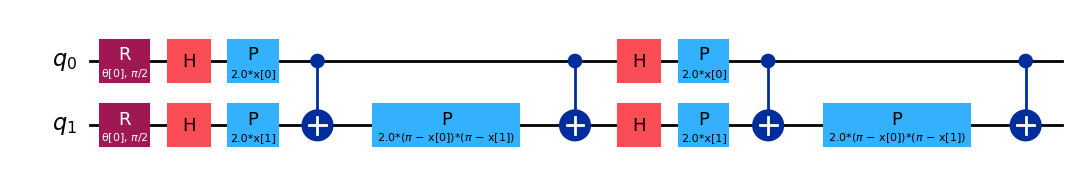

In [23]:
training_params = ParameterVector("θ", 1)
feature_map0 = QuantumCircuit(feature_dimension)
feature_map0.ry(training_params[0], 0)
feature_map0.ry(training_params[0], 1)

#feature_map1 = ZFeatureMap(feature_dimension)
feature_map1 = ZZFeatureMap(feature_dimension)
#feature_map1 = PauliFeatureMap(feature_dimension=feature_dimension, reps=1, paulis=['Y'])

feature_map = feature_map0.compose(feature_map1)
feature_map.decompose().draw('mpl')

In [24]:
kernel = TrainableFidelityQuantumKernel(feature_map=feature_map, training_parameters=training_params)
cb_qkt = QKTCallback()
spsa_opt = SPSA(maxiter=10, callback=cb_qkt.callback)
loss = SVRLoss()
qkt = QuantumKernelTrainer(quantum_kernel=kernel, loss=loss, optimizer=spsa_opt, initial_point=[np.pi / 2])

In [25]:
qka_results = qkt.fit(X_train, y_train)
optimized_kernel = qka_results.quantum_kernel
print(qka_results)

{   'optimal_circuit': None,
    'optimal_parameters': {ParameterVectorElement(θ[0]): 0.7899302757957097},
    'optimal_point': array([0.78993028]),
    'optimal_value': -231.08299696617223,
    'optimizer_evals': 30,
    'optimizer_result': None,
    'optimizer_time': None,
    'quantum_kernel': <qiskit_machine_learning.kernels.trainable_fidelity_quantum_kernel.TrainableFidelityQuantumKernel object at 0x73cb8781d700>}


In [37]:
#fit classical SVR with optimized quantum kernel
svr = SVR(kernel=optimized_kernel.evaluate, epsilon=0) 
svr.fit(X_train, y_train)

mse = mean_squared_error(svr.predict(X_test), y_test)
rmse = np.sqrt(mse)
print("Root Mean Squared Error:", rmse/len(y_test))

Root Mean Squared Error: 0.589489400448213


In [38]:
#fit classical SVR with NOT optimized quantum kernel
kernel = FidelityQuantumKernel(feature_map=feature_map1)
svr = SVR(kernel=kernel.evaluate, epsilon=0) 
svr.fit(X_train, y_train)

mse = mean_squared_error(svr.predict(X_test), y_test)
rmse = np.sqrt(mse)
print("Root Mean Squared Error:", rmse/len(y_test))

Root Mean Squared Error: 0.5833266463693073


In [39]:
#fit classical SVR with rbf kernel
svr = SVR(kernel='rbf', epsilon=0) 
svr.fit(X_train, y_train)

mse = mean_squared_error(svr.predict(X_test), y_test)
rmse = np.sqrt(mse)
print("Root Mean Squared Error:", rmse/len(y_test))

Root Mean Squared Error: 0.2543508062321694


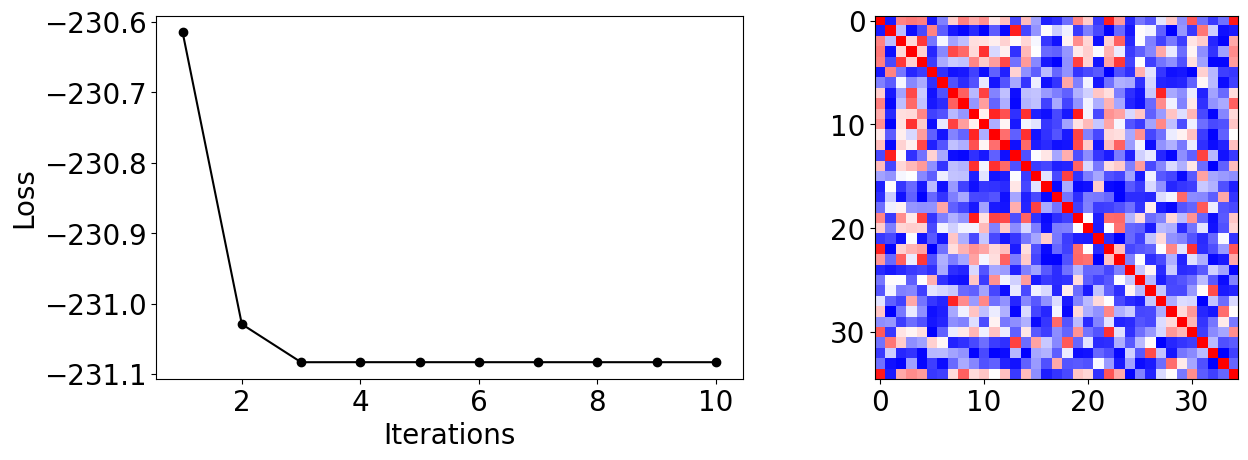

In [40]:
plot_data = cb_qkt.get_callback_data()  # callback data
K = optimized_kernel.evaluate(X_train)  # kernel matrix evaluated on the training samples

plt.rcParams["font.size"] = 20
fig, ax = plt.subplots(1, 2, figsize=(14, 5))
ax[0].plot([i + 1 for i in range(len(plot_data[0]))], np.array(plot_data[2]), c="k", marker="o")
ax[0].set_xlabel("Iterations")
ax[0].set_ylabel("Loss")
ax[1].imshow(K, cmap=matplotlib.colormaps["bwr"])
fig.tight_layout()
plt.show()

In [41]:
kernel_loss = SVRLoss().get_variational_callable(optimized_kernel, X_train, y_train)
NUM_GRID_POINTS = 100
loss_values = [kernel_loss([val]) for val in np.linspace(0, 2 * np.pi, NUM_GRID_POINTS)]

plt.rcParams["font.size"] = 15
plt.figure(figsize=(8, 4))
plt.plot(np.linspace(0, 2 * np.pi, NUM_GRID_POINTS), loss_values)
plt.xlabel("θ")
plt.ylabel("Kernel Loss")
plt.show()

KeyboardInterrupt: 